1.Code minh họa cho Logistic Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import logging
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from datetime import datetime
import plotly.graph_objects as go
import seaborn as sns

Đóng tất cả các biểu đồ trước khi chạy

In [2]:
plt.close('all')


Thiết lập logging

In [3]:
logging.basicConfig(
    filename='training.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

In [4]:
class LogisticRegressionModel:
    """Lớp triển khai Logistic Regression với Gradient Descent."""

    def __init__(self, learning_rate=0.1, epochs=200, early_stopping_patience=10, verbose=True):
        """Khởi tạo mô hình với các siêu tham số."""
        self.lr = learning_rate
        self.epochs = epochs
        self.patience = early_stopping_patience
        self.verbose = verbose
        self.weights = None
        self.bias = None
        self.scaler = StandardScaler()
        self.train_losses = []
        self.val_losses = []

    @staticmethod
    def sigmoid(z):
        """Hàm sigmoid với giới hạn để tránh tràn số."""
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def cross_entropy_loss(y_true, y_pred):
        """Hàm mất mát cross-entropy."""
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def fit(self, X_train, y_train, X_val, y_val):
        """Huấn luyện mô hình."""
        try:
            if X_train.shape[0] != y_train.shape[0] or X_val.shape[0] != y_val.shape[0]:
                raise ValueError("Kích thước của X và y không khớp.")

            X_train = self.scaler.fit_transform(X_train)
            X_val = self.scaler.transform(X_val)

            n_samples, n_features = X_train.shape
            self.weights = np.random.randn(n_features) * 0.01
            self.bias = 0

            best_val_loss = float('inf')
            patience_counter = 0

            for epoch in range(self.epochs):
                z = np.dot(X_train, self.weights) + self.bias
                y_pred = self.sigmoid(z)

                train_loss = self.cross_entropy_loss(y_train, y_pred)
                val_pred = self.sigmoid(np.dot(X_val, self.weights) + self.bias)
                val_loss = self.cross_entropy_loss(y_val, val_pred)

                self.train_losses.append(train_loss)
                self.val_losses.append(val_loss)

                logging.info(f'Epoch {epoch+1}/{self.epochs} - Train Loss: {train_loss:.6f} - Val Loss: {val_loss:.6f}')

                if self.verbose and (epoch + 1) % 50 == 0:
                    print(f'Epoch {epoch+1}/{self.epochs} - Train Loss: {train_loss:.6f} - Val Loss: {val_loss:.6f}')

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= self.patience:
                        logging.info(f'Early stopping at epoch {epoch+1}')
                        if self.verbose:
                            print(f'Early stopping at epoch {epoch+1}')
                        break

                dw = (1/n_samples) * np.dot(X_train.T, (y_pred - y_train))
                db = (1/n_samples) * np.sum(y_pred - y_train)

                self.weights -= self.lr * dw
                self.bias -= self.lr * db

            return self.train_losses, self.val_losses

        except Exception as e:
            logging.error(f'Error during training: {str(e)}')
            raise

    def predict(self, X):
        """Dự đoán nhãn lớp."""
        X = self.scaler.transform(X)
        z = np.dot(X, self.weights) + self.bias
        return (self.sigmoid(z) >= 0.5).astype(int)

    def predict_proba(self, X):
        """Dự đoán xác suất."""
        X = self.scaler.transform(X)
        z = np.dot(X, self.weights) + self.bias
        return self.sigmoid(z)

    def plot_loss(self):
        """Vẽ đồ thị mất mát."""
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_losses, label='Training Loss', color='blue', linewidth=2, marker='o', markersize=4)
        plt.plot(self.val_losses, label='Validation Loss', color='orange', linewidth=2, marker='s', markersize=4)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Cross-Entropy Loss', fontsize=12)
        plt.title('Training and Validation Loss for Logistic Regression', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=10)
        plt.tight_layout()
        plt.savefig('logistic_loss_plot.png')
        plt.show()

    def plot_3d_decision_boundary(self, X, y, elev=30, azim=-60, title_suffix=""):
        """Vẽ biểu đồ 3D với mặt phẳng phân cách, tùy chỉnh góc nhìn."""
        if X.shape[0] == 0 or X.shape[1] < 2:
            raise ValueError("Dữ liệu đầu vào không hợp lệ: X phải có ít nhất 2 cột và không rỗng.")

        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter(X[y == 0][:, 0], X[y == 0][:, 1], y[y == 0], color='red', label='Class 0', s=60, alpha=0.9)
        ax.scatter(X[y == 1][:, 0], X[y == 1][:, 1], y[y == 1], color='blue', label='Class 1', s=60, alpha=0.9)

        x1_range = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 200)
        x2_range = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 200)
        x1, x2 = np.meshgrid(x1_range, x2_range)

        points = np.vstack([x1.ravel(), x2.ravel()]).T
        points_scaled = self.scaler.transform(points)
        z = self.sigmoid(np.dot(points_scaled, self.weights) + self.bias).reshape(x1.shape)

        surface = ax.plot_surface(x1, x2, z, cmap='viridis', alpha=0.7, rstride=1, cstride=1, linewidth=0, antialiased=True)

        fig.colorbar(surface, ax=ax, shrink=0.5, aspect=5, label='Probability', pad=0.1)

        ax.set_zlim(0, 1)
        ax.view_init(elev=elev, azim=azim)
        ax.set_xlabel('Feature 1', fontsize=14, labelpad=15)
        ax.set_ylabel('Feature 2', fontsize=14, labelpad=15)
        ax.set_zlabel('Probability', fontsize=14, labelpad=15)
        ax.set_title(f'3D Decision Boundary for Logistic Regression {title_suffix}', fontsize=16, pad=25)
        plt.legend(fontsize=12, loc='upper right')
        plt.tight_layout()
        plt.savefig(f'logistic_3d_surface_{title_suffix}.png')
        plt.show()

    def plot_3d_decision_boundary_interactive(self, X, y, title_suffix=""):
        """Vẽ biểu đồ 3D tương tác với mặt phẳng phân cách sử dụng Plotly."""
        if X.shape[0] == 0 or X.shape[1] < 2:
            raise ValueError("Dữ liệu đầu vào không hợp lệ: X phải có ít nhất 2 cột và không rỗng.")

        x1_range = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100)
        x2_range = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100)
        x1, x2 = np.meshgrid(x1_range, x2_range)
        points = np.vstack([x1.ravel(), x2.ravel()]).T
        points_scaled = self.scaler.transform(points)
        z = self.sigmoid(np.dot(points_scaled, self.weights) + self.bias).reshape(x1.shape)

        fig = go.Figure()
        fig.add_trace(go.Scatter3d(
            x=X[y == 0][:, 0], y=X[y == 0][:, 1], z=y[y == 0],
            mode='markers', marker=dict(size=5, color='red'), name='Class 0'
        ))
        fig.add_trace(go.Scatter3d(
            x=X[y == 1][:, 0], y=X[y == 1][:, 1], z=y[y == 1],
            mode='markers', marker=dict(size=5, color='blue'), name='Class 1'
        ))
        fig.add_trace(go.Surface(
            x=x1, y=x2, z=z, colorscale='Viridis', opacity=0.7, showscale=True
        ))

        fig.update_layout(
            title=f'3D Decision Boundary for Logistic Regression {title_suffix}',
            scene=dict(
                xaxis_title='Feature 1',
                yaxis_title='Feature 2',
                zaxis_title='Probability',
                zaxis=dict(range=[0, 1])
            )
        )
        fig.write_html(f'logistic_3d_interactive_{title_suffix}.html')
        fig.show()

    def plot_feature_importance(self, feature_names=None):
        """Vẽ biểu đồ tầm quan trọng của các đặc trưng dựa trên trọng số."""
        if self.weights is None:
            raise ValueError("Mô hình chưa được huấn luyện.")
        if feature_names is None:
            feature_names = [f'Feature {i+1}' for i in range(len(self.weights))]
        plt.figure(figsize=(10, 6))
        plt.bar(feature_names, np.abs(self.weights), color='skyblue')
        plt.xlabel('Đặc trưng', fontsize=12)
        plt.ylabel('Giá trị tuyệt đối của trọng số', fontsize=12)
        plt.title('Tầm quan trọng của đặc trưng trong Logistic Regression', fontsize=14)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('feature_importance.png')
        plt.show()

    def plot_confusion_matrix(self, X, y, title_suffix=""):
        """Vẽ ma trận nhầm lẫn sử dụng seaborn."""
        y_pred = self.predict(X)
        cm = confusion_matrix(y, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel('Nhãn dự đoán', fontsize=12)
        plt.ylabel('Nhãn thực tế', fontsize=12)
        plt.title(f'Ma trận nhầm lẫn {title_suffix}', fontsize=14)
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{title_suffix}.png')
        plt.show()

Hàm so sánh với sklearn và vẽ ranh giới quyết định 2D

In [5]:
def compare_with_sklearn(custom_model, X_train, y_train, X_val, y_val):
    """So sánh mô hình tùy chỉnh với mô hình sklearn và vẽ ranh giới quyết định 2D."""
    sklearn_model = LogisticRegression(max_iter=1000, random_state=42)
    X_train_scaled = custom_model.scaler.fit_transform(X_train)
    X_val_scaled = custom_model.scaler.transform(X_val)
    sklearn_model.fit(X_train_scaled, y_train)

    y_pred_custom = custom_model.predict(X_val)
    y_pred_sklearn = sklearn_model.predict(X_val_scaled)

    acc_custom = accuracy_score(y_val, y_pred_custom)
    acc_sklearn = accuracy_score(y_val, y_pred_sklearn)
    precision_custom = precision_score(y_val, y_pred_custom)
    precision_sklearn = precision_score(y_val, y_pred_sklearn)
    recall_custom = recall_score(y_val, y_pred_custom)
    recall_sklearn = recall_score(y_val, y_pred_sklearn)
    f1_custom = f1_score(y_val, y_pred_custom)
    f1_sklearn = f1_score(y_val, y_pred_sklearn)

    print("So sánh hiệu suất:")
    print(f"Accuracy - Custom: {acc_custom:.4f}, Sklearn: {acc_sklearn:.4f}")
    print(f"Precision - Custom: {precision_custom:.4f}, Sklearn: {precision_sklearn:.4f}")
    print(f"Recall - Custom: {recall_custom:.4f}, Sklearn: {recall_sklearn:.4f}")
    print(f"F1-Score - Custom: {f1_custom:.4f}, Sklearn: {f1_sklearn:.4f}")
    logging.info(f"Accuracy - Custom: {acc_custom:.4f}, Sklearn: {acc_sklearn:.4f}")
    logging.info(f"Precision - Custom: {precision_custom:.4f}, Sklearn: {precision_sklearn:.4f}")
    logging.info(f"Recall - Custom: {recall_custom:.4f}, Sklearn: {recall_sklearn:.4f}")
    logging.info(f"F1-Score - Custom: {f1_custom:.4f}, Sklearn: {f1_sklearn:.4f}")

    plt.figure(figsize=(12, 5))
    x1_min, x1_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    x2_min, x2_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x1_min, x1_max, 200), np.linspace(x2_min, x2_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_scaled = custom_model.scaler.transform(grid)

    Z_custom = custom_model.predict(grid).reshape(xx.shape)
    Z_sklearn = sklearn_model.predict(grid_scaled).reshape(xx.shape)

    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, Z_custom, cmap='RdBu', alpha=0.3)
    plt.scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], c='red', label='Class 0', alpha=0.8)
    plt.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], c='blue', label='Class 1', alpha=0.8)
    plt.title('Custom Logistic Regression', fontsize=12)
    plt.xlabel('Feature 1', fontsize=10)
    plt.ylabel('Feature 2', fontsize=10)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.contourf(xx, yy, Z_sklearn, cmap='RdBu', alpha=0.3)
    plt.scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], c='red', label='Class 0', alpha=0.8)
    plt.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], c='blue', label='Class 1', alpha=0.8)
    plt.title('Sklearn Logistic Regression', fontsize=12)
    plt.xlabel('Feature 1', fontsize=10)
    plt.ylabel('Feature 2', fontsize=10)
    plt.legend()

    plt.tight_layout()
    plt.savefig('logistic_decision_boundary.png')
    plt.show()

Tạo dữ liệu giả lập cho Logistic Regression

In [6]:
X_lr, y_lr = make_classification(
    n_samples=1000,
    n_features=2,
    n_classes=2,
    n_clusters_per_class=1,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    random_state=42
)
X_train_lr, X_val_lr, y_train_lr, y_val_lr = train_test_split(X_lr, y_lr, test_size=0.2, random_state=42)

Hiển thị toàn bộ 1000 mẫu dữ liệu giả lập Logistic Regression

In [7]:
"""Hiển thị toàn bộ 1000 mẫu dữ liệu giả lập Logistic Regression"""
# Lưu dữ liệu vào file CSV
np.savetxt('logistic_data_X.csv', X_lr, delimiter=',', header='Feature_1,Feature_2', comments='')
np.savetxt('logistic_data_y.csv', y_lr, delimiter=',', header='Label', comments='')
print("Dữ liệu Logistic Regression đã được lưu vào 'logistic_data_X.csv' và 'logistic_data_y.csv'")

# In toàn bộ 1000 mẫu
print("\nHiển thị toàn bộ 1000 mẫu dữ liệu Logistic Regression:")
for i in range(len(X_lr)):
    print(f"Mẫu {i+1}: X = {X_lr[i]}, y = {y_lr[i]}")
print("Đã hiển thị toàn bộ 1000 mẫu dữ liệu Logistic Regression.")
print("\n")

Dữ liệu Logistic Regression đã được lưu vào 'logistic_data_X.csv' và 'logistic_data_y.csv'

Hiển thị toàn bộ 1000 mẫu dữ liệu Logistic Regression:
Mẫu 1: X = [0.60103418 1.5353525 ], y = 1
Mẫu 2: X = [ 0.75594526 -1.1723519 ], y = 0
Mẫu 3: X = [ 1.35447877 -0.94852841], y = 0
Mẫu 4: X = [3.1030897  0.23348484], y = 0
Mẫu 5: X = [0.75317779 0.78751427], y = 1
Mẫu 6: X = [1.0600389  0.58798641], y = 1
Mẫu 7: X = [ 0.36855907 -1.35598715], y = 0
Mẫu 8: X = [0.62515477 0.91539778], y = 1
Mẫu 9: X = [0.54901996 1.45381422], y = 1
Mẫu 10: X = [0.74616631 1.08854866], y = 1
Mẫu 11: X = [ 2.16500456 -0.36476962], y = 0
Mẫu 12: X = [ 1.36702575 -0.71923613], y = 1
Mẫu 13: X = [0.82265269 1.28245544], y = 1
Mẫu 14: X = [ 2.06431386 -0.28638103], y = 0
Mẫu 15: X = [ 1.45941827 -0.78635092], y = 0
Mẫu 16: X = [0.35523359 1.5413809 ], y = 1
Mẫu 17: X = [ 2.78403394 -0.02389532], y = 0
Mẫu 18: X = [-0.89482916  2.36200585], y = 1
Mẫu 19: X = [ 2.11992066 -0.11793322], y = 1
Mẫu 20: X = [-0.35445947 

Khởi tạo và huấn luyện mô hình Logistic Regression

In [8]:
model_lr = LogisticRegressionModel(learning_rate=0.1, epochs=200, early_stopping_patience=10, verbose=True)
train_losses_lr, val_losses_lr = model_lr.fit(X_train_lr, y_train_lr, X_val_lr, y_val_lr)

Epoch 50/200 - Train Loss: 0.380637 - Val Loss: 0.400991
Epoch 100/200 - Train Loss: 0.312277 - Val Loss: 0.338410
Epoch 150/200 - Train Loss: 0.284426 - Val Loss: 0.313363
Epoch 200/200 - Train Loss: 0.269579 - Val Loss: 0.300362


Vẽ đồ thị mất mát

Biểu đồ mất mát của Logistic Regression:


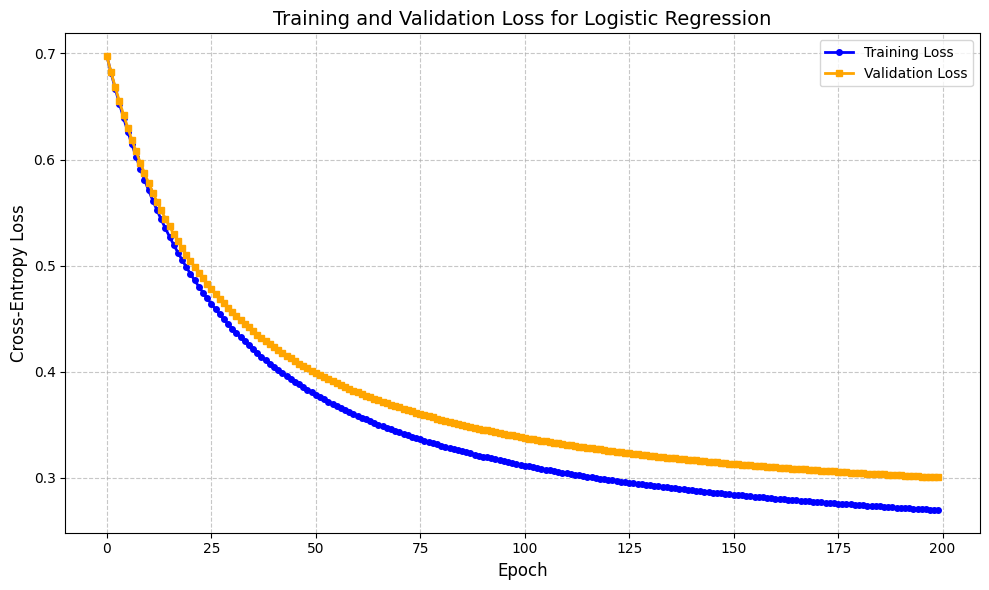

In [9]:
print("Biểu đồ mất mát của Logistic Regression:")
model_lr.plot_loss()
print("\n")

So sánh với sklearn và vẽ ranh giới quyết định

So sánh với mô hình sklearn và vẽ ranh giới quyết định:
So sánh hiệu suất:
Accuracy - Custom: 0.8950, Sklearn: 0.9000
Precision - Custom: 0.9213, Sklearn: 0.9222
Recall - Custom: 0.8542, Sklearn: 0.8646
F1-Score - Custom: 0.8865, Sklearn: 0.8925


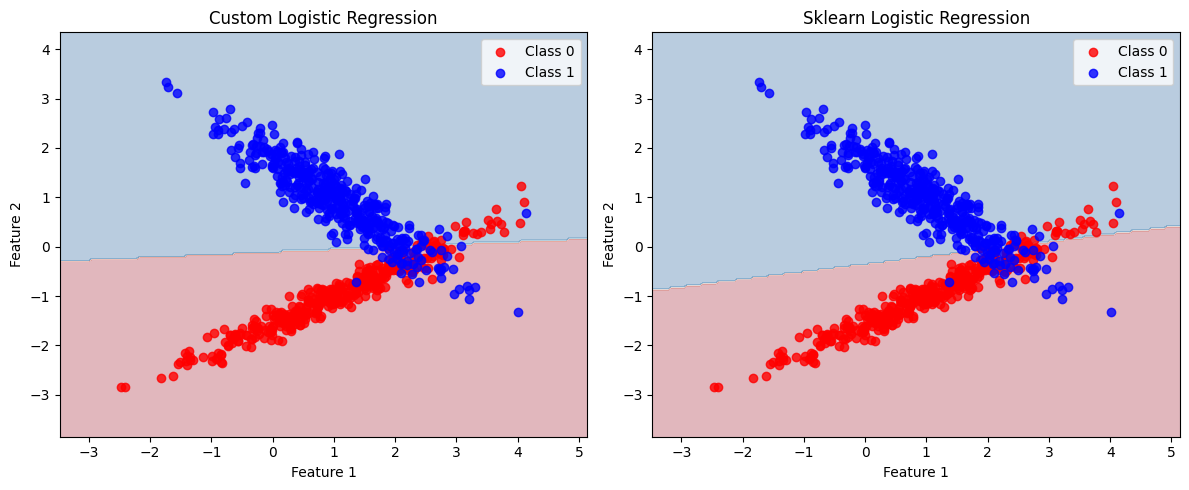

In [10]:
print("So sánh với mô hình sklearn và vẽ ranh giới quyết định:")
compare_with_sklearn(model_lr, X_train_lr, y_train_lr, X_val_lr, y_val_lr)
print("\n")

Vẽ biểu đồ 3D (góc nhìn 1)

Biểu đồ 3D của Logistic Regression (Góc nhìn 1 - elev=30, azim=-60):


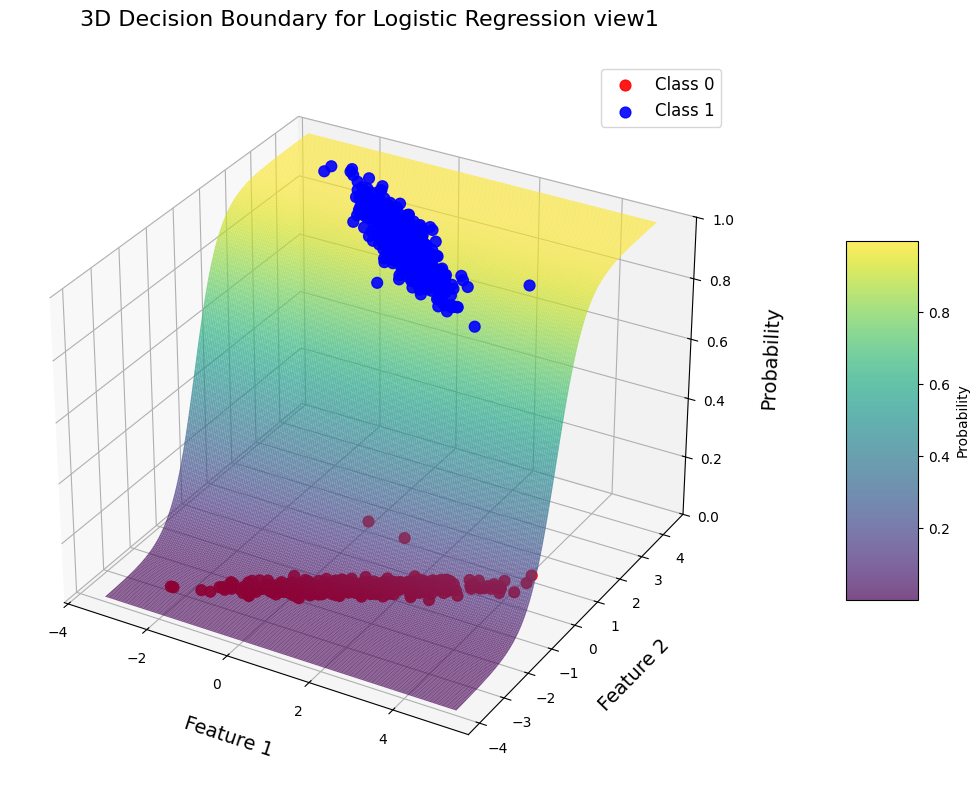

In [11]:
print("Biểu đồ 3D của Logistic Regression (Góc nhìn 1 - elev=30, azim=-60):")
model_lr.plot_3d_decision_boundary(X_lr, y_lr, elev=30, azim=-60, title_suffix="view1")
print("\n")

Vẽ biểu đồ 3D (góc nhìn 2)

Biểu đồ 3D của Logistic Regression (Góc nhìn 2 - elev=20, azim=90):


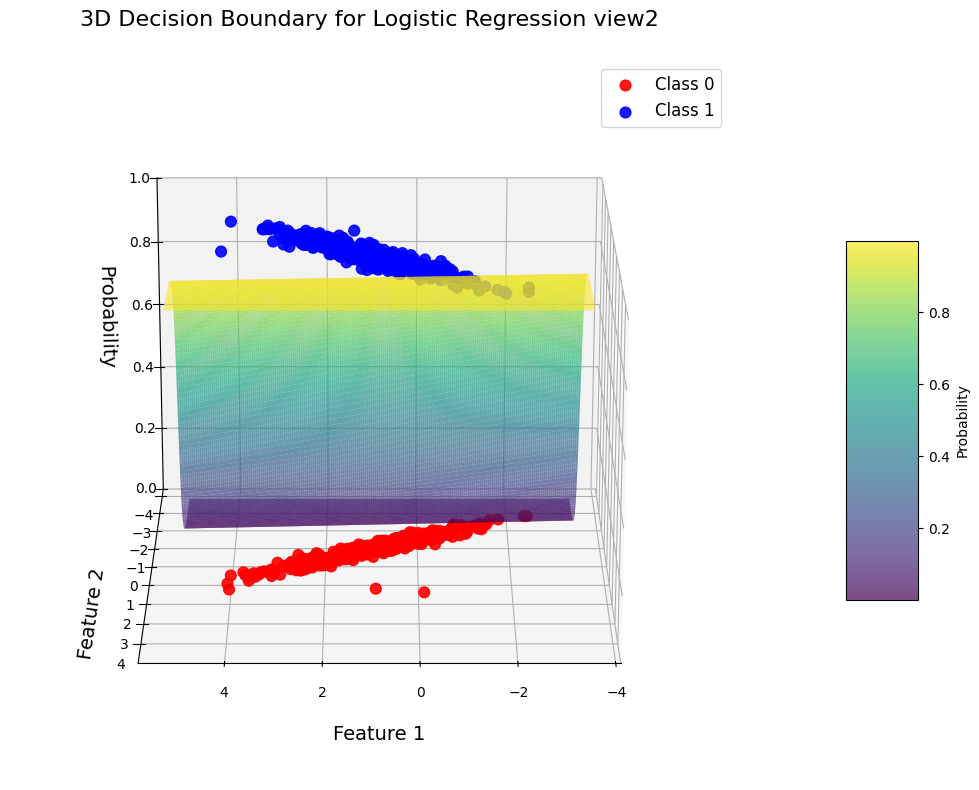

In [12]:
print("Biểu đồ 3D của Logistic Regression (Góc nhìn 2 - elev=20, azim=90):")
model_lr.plot_3d_decision_boundary(X_lr, y_lr, elev=20, azim=90, title_suffix="view2")
print("\n")

Vẽ biểu đồ 3D tương tác

In [13]:
print("Biểu đồ 3D tương tác của Logistic Regression:")
model_lr.plot_3d_decision_boundary_interactive(X_lr, y_lr, title_suffix="interactive")
print("\n")

Biểu đồ 3D tương tác của Logistic Regression:


Vẽ biểu đồ tầm quan trọng của đặc trưng

Biểu đồ tầm quan trọng của đặc trưng:


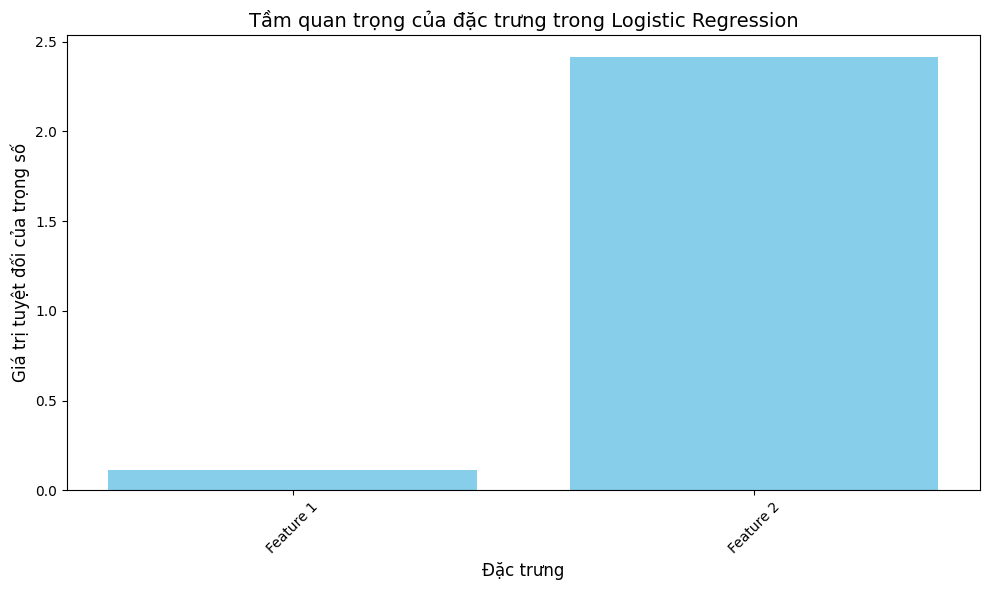

In [14]:
print("Biểu đồ tầm quan trọng của đặc trưng:")
model_lr.plot_feature_importance(feature_names=['Feature 1', 'Feature 2'])
print("\n")

Vẽ ma trận nhầm lẫn

Ma trận nhầm lẫn của Logistic Regression:


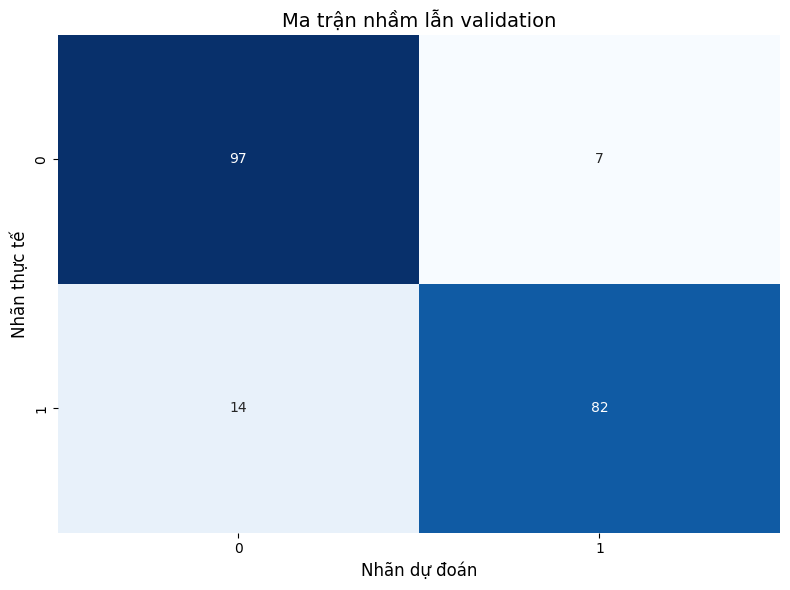

In [15]:
print("Ma trận nhầm lẫn của Logistic Regression:")
model_lr.plot_confusion_matrix(X_val_lr, y_val_lr, title_suffix="validation")
print("\n")

2. Code minh họa cho Multi-Layer Perceptron (MLP)

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import logging
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime

Đóng tất cả các biểu đồ trước khi chạy

In [17]:
plt.close('all')

Thiết lập logging

In [18]:
logging.basicConfig(
    filename='training.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

In [19]:
class MLPModel:
    """Lớp triển khai Multi-Layer Perceptron cho bài toán Regression."""

    def __init__(self, layer_sizes, learning_rate=0.01, epochs=200, early_stopping_patience=10,
                 activation='relu', verbose=True):
        """Khởi tạo mô hình với các siêu tham số."""
        self.layer_sizes = layer_sizes
        self.lr = learning_rate
        self.epochs = epochs
        self.patience = early_stopping_patience
        self.activation = activation
        self.verbose = verbose
        self.weights = []
        self.biases = []
        self.scaler = StandardScaler()
        self.train_losses = []
        self.val_losses = []

    def initialize_parameters(self):
        """Khởi tạo trọng số và bias sử dụng Xavier initialization."""
        for i in range(len(self.layer_sizes) - 1):
            limit = np.sqrt(6 / (self.layer_sizes[i] + self.layer_sizes[i+1]))
            weight = np.random.uniform(-limit, limit, (self.layer_sizes[i], self.layer_sizes[i+1]))
            bias = np.zeros((1, self.layer_sizes[i+1]))
            self.weights.append(weight)
            self.biases.append(bias)

    def activation_function(self, z):
        """Hàm kích hoạt."""
        if self.activation == 'relu':
            return np.maximum(0, z)
        elif self.activation == 'tanh':
            return np.tanh(z)
        else:
            raise ValueError(f'Unsupported activation function: {self.activation}')

    def activation_derivative(self, z):
        """Đạo hàm của hàm kích hoạt."""
        if self.activation == 'relu':
            return np.where(z > 0, 1, 0)
        elif self.activation == 'tanh':
            return 1 - np.tanh(z) ** 2
        else:
            raise ValueError(f'Unsupported activation function: {self.activation}')

    @staticmethod
    def mse_loss(y_true, y_pred):
        """Hàm mất mát Mean Squared Error."""
        return np.mean((y_true - y_pred) ** 2)

    def forward(self, X):
        """Lan truyền xuôi."""
        activations = [X]
        z_values = []

        for i in range(len(self.weights)):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            z_values.append(z)
            if i < len(self.weights) - 1:
                activations.append(self.activation_function(z))
            else:
                activations.append(z)
        return activations, z_values

    def backward(self, X, y, activations, z_values):
        """Lan truyền ngược."""
        m = X.shape[0]
        delta = (2/m) * (activations[-1] - y)

        for i in range(len(self.weights) - 1, -1, -1):
            dw = np.dot(activations[i].T, delta)
            db = np.sum(delta, axis=0, keepdims=True)

            if i > 0:
                delta = np.dot(delta, self.weights[i].T) * self.activation_derivative(z_values[i-1])

            self.weights[i] -= self.lr * dw
            self.biases[i] -= self.lr * db

    def fit(self, X_train, y_train, X_val, y_val):
        """Huấn luyện mô hình."""
        try:
            if X_train.shape[0] != y_train.shape[0] or X_val.shape[0] != y_val.shape[0]:
                raise ValueError("Kích thước của X và y không khớp.")
            if X_train.shape[0] == 0 or X_val.shape[0] == 0:
                raise ValueError("Dữ liệu huấn luyện hoặc kiểm tra rỗng.")

            X_train = self.scaler.fit_transform(X_train)
            X_val = self.scaler.transform(X_val)
            y_train = y_train.reshape(-1, 1)
            y_val = y_val.reshape(-1, 1)

            self.initialize_parameters()

            best_val_loss = float('inf')
            patience_counter = 0

            for epoch in range(self.epochs):
                activations_train, z_values_train = self.forward(X_train)
                y_pred = activations_train[-1]

                train_loss = self.mse_loss(y_train, y_pred)
                activations_val, _ = self.forward(X_val)
                val_pred = activations_val[-1]
                val_loss = self.mse_loss(y_val, val_pred)

                self.train_losses.append(train_loss)
                self.val_losses.append(val_loss)

                logging.info(f'Epoch {epoch+1}/{self.epochs} - Train Loss: {train_loss:.6f} - Val Loss: {val_loss:.6f}')

                if self.verbose and (epoch + 1) % 50 == 0:
                    print(f'Epoch {epoch+1}/{self.epochs} - Train Loss: {train_loss:.6f} - Val Loss: {val_loss:.6f}')

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= self.patience:
                        logging.info(f'Early stopping at epoch {epoch+1}')
                        if self.verbose:
                            print(f'Early stopping at epoch {epoch+1}')
                        break

                self.backward(X_train, y_train, activations_train, z_values_train)

            return self.train_losses, self.val_losses

        except Exception as e:
            logging.error(f'Error during training: {str(e)}')
            raise

    def predict(self, X):
        """Dự đoán giá trị."""
        X = self.scaler.transform(X)
        activations, _ = self.forward(X)
        return activations[-1]

    def plot_loss(self):
        """Vẽ đồ thị mất mát."""
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_losses, label='Training Loss', color='green', linewidth=2, marker='o', markersize=4)
        plt.plot(self.val_losses, label='Validation Loss', color='red', linewidth=2, marker='s', markersize=4)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Mean Squared Error Loss', fontsize=12)
        plt.title('Training and Validation Loss for MLP', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=10)
        plt.tight_layout()
        plt.savefig('mlp_loss_plot.png')
        plt.show()

    def plot_3d_regression_surface(self, X, y, elev=30, azim=45, title_suffix=""):
        """Vẽ biểu đồ 3D với bề mặt hồi quy."""
        if X.shape[0] == 0 or X.shape[1] < 2:
            raise ValueError("Dữ liệu đầu vào không hợp lệ: X phải có ít nhất 2 cột và không rỗng.")

        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter(X[:, 0], X[:, 1], y, color='blue', label='Data Points', s=60, alpha=0.9)

        x1_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 200)
        x2_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 200)
        x1, x2 = np.meshgrid(x1_range, x2_range)

        points = np.vstack([x1.ravel(), x2.ravel()]).T
        points_scaled = self.scaler.transform(points)
        z = self.predict(points_scaled).reshape(x1.shape)

        surface = ax.plot_surface(x1, x2, z, cmap='coolwarm', alpha=0.5, rstride=1, cstride=1, linewidth=0, antialiased=True)

        fig.colorbar(surface, ax=ax, shrink=0.5, aspect=5, label='Target Value', pad=0.1)

        ax.view_init(elev=elev, azim=azim)
        ax.set_xlabel('Feature 1', fontsize=14, labelpad=15)
        ax.set_ylabel('Feature 2', fontsize=14, labelpad=15)
        ax.set_zlabel('Target Value', fontsize=14, labelpad=15)
        ax.set_title(f'3D Regression Surface for MLP {title_suffix}', fontsize=16, pad=25)
        plt.legend(fontsize=12, loc='upper right')
        plt.tight_layout()
        plt.savefig(f'mlp_3d_surface_{title_suffix}.png')
        plt.show()

    def plot_2d_prediction(self, X_val, y_val, y_pred):
        """Vẽ biểu đồ 2D so sánh giá trị thực và dự đoán."""
        plt.figure(figsize=(10, 6))
        plt.scatter(y_val, y_pred, color='blue', label='Predicted vs True', alpha=0.5)
        plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', label='Ideal')
        plt.xlabel('True Values', fontsize=12)
        plt.ylabel('Predicted Values', fontsize=12)
        plt.title('MLP: True vs Predicted Values', fontsize=14)
        plt.legend(fontsize=10)
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('mlp_2d_prediction.png')
        plt.show()

Hàm so sánh với sklearn

In [20]:
def compare_with_sklearn_mlp(custom_model, X_train, y_train, X_val, y_val):
    """So sánh mô hình MLP tùy chỉnh với MLPRegressor của sklearn."""
    sklearn_model = MLPRegressor(hidden_layer_sizes=(10, 5), activation='relu', learning_rate_init=0.01,
                                 max_iter=200, early_stopping=True, validation_fraction=0.2, random_state=42)
    X_train_scaled = custom_model.scaler.fit_transform(X_train)
    X_val_scaled = custom_model.scaler.transform(X_val)
    sklearn_model.fit(X_train_scaled, y_train)

    y_pred_custom = custom_model.predict(X_val).ravel()
    y_pred_sklearn = sklearn_model.predict(X_val_scaled)

    mse_custom = mean_squared_error(y_val, y_pred_custom)
    mse_sklearn = mean_squared_error(y_val, y_pred_sklearn)
    r2_custom = r2_score(y_val, y_pred_custom)
    r2_sklearn = r2_score(y_val, y_pred_sklearn)

    print(f"MSE - Custom: {mse_custom:.6f}, Sklearn: {mse_sklearn:.6f}")
    print(f"R² Score - Custom: {r2_custom:.6f}, Sklearn: {r2_sklearn:.6f}")
    logging.info(f"MSE - Custom: {mse_custom:.6f}, Sklearn: {mse_sklearn:.6f}")
    logging.info(f"R² Score - Custom: {r2_custom:.6f}, Sklearn: {r2_sklearn:.6f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(y_val, y_pred_custom, color='blue', label='Custom MLP', alpha=0.5)
    plt.scatter(y_val, y_pred_sklearn, color='orange', label='Sklearn MLP', alpha=0.5)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', label='Ideal')
    plt.xlabel('True Values', fontsize=12)
    plt.ylabel('Predicted Values', fontsize=12)
    plt.title('MLP: True vs Predicted Values Comparison', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True)
    plt.savefig('mlp_prediction_comparison.png')
    plt.show()

Tạo dữ liệu giả lập cho MLP

In [21]:
X_mlp, y_mlp = make_regression(n_samples=1000, n_features=2, noise=0.1, random_state=42)
X_train_mlp, X_val_mlp, y_train_mlp, y_val_mlp = train_test_split(X_mlp, y_mlp, test_size=0.2, random_state=42)

Hiển thị toàn bộ 1000 mẫu dữ liệu giả lập MLP

In [22]:
np.savetxt('mlp_data_X.csv', X_mlp, delimiter=',', header='Feature_1,Feature_2', comments='')
np.savetxt('mlp_data_y.csv', y_mlp, delimiter=',', header='Target', comments='')
print("Dữ liệu MLP đã được lưu vào 'mlp_data_X.csv' và 'mlp_data_y.csv'")

# In toàn bộ 1000 mẫu
print("\nHiển thị toàn bộ 1000 mẫu dữ liệu MLP:")
for i in range(len(X_mlp)):
    print(f"Mẫu {i+1}: X = {X_mlp[i]}, y = {y_mlp[i]}")
print("Đã hiển thị toàn bộ 1000 mẫu dữ liệu MLP.")
print("\n")

Dữ liệu MLP đã được lưu vào 'mlp_data_X.csv' và 'mlp_data_y.csv'

Hiển thị toàn bộ 1000 mẫu dữ liệu MLP:
Mẫu 1: X = [-0.16711808  0.14671369], y = -5.926649928798655
Mẫu 2: X = [-0.02090159  0.11732738], y = -0.20245770154512546
Mẫu 3: X = [0.15041891 0.364961  ], y = 8.625180140072182
Mẫu 4: X = [0.55560447 0.08958068], y = 23.044850286859035
Mẫu 5: X = [ 0.05820872 -1.1429703 ], y = -5.265219576802926
Mẫu 6: X = [-0.96697614 -0.04771136], y = -39.53680498767571
Mẫu 7: X = [-1.00162001 -0.28110029], y = -42.59813408929047
Mẫu 8: X = [-1.66940528  0.54336019], y = -64.25228191222696
Mẫu 9: X = [ 0.11958037 -0.97306894], y = -1.4818314467578102
Mẫu 10: X = [-1.40631746 -0.08310557], y = -57.723854391127155
Mẫu 11: X = [0.89959988 0.30729952], y = 38.63418859784865
Mẫu 12: X = [-1.34712629 -0.97161404], y = -61.2173136865138
Mẫu 13: X = [-0.56216803 -0.20922187], y = -24.16763843650012
Mẫu 14: X = [-0.4660365  -1.59470307], y = -29.51890515836436
Mẫu 15: X = [0.6141667  0.75750771], y = 

Khởi tạo và huấn luyện mô hình MLP

In [23]:
model_mlp = MLPModel(layer_sizes=[2, 10, 5, 1], learning_rate=0.01, epochs=200,
                     early_stopping_patience=10, activation='relu', verbose=True)
train_losses_mlp, val_losses_mlp = model_mlp.fit(X_train_mlp, y_train_mlp, X_val_mlp, y_val_mlp)

Early stopping at epoch 26


Vẽ đồ thị mất mát cho MLP

Biểu đồ mất mát của MLP:


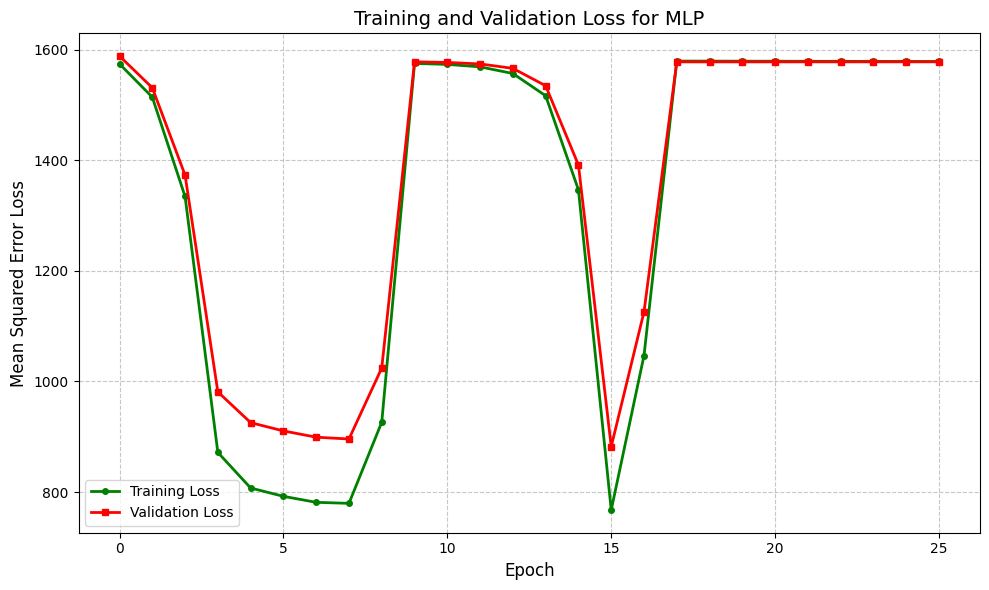

In [24]:
print("Biểu đồ mất mát của MLP:")
model_mlp.plot_loss()
print("\n")


Vẽ biểu đồ 2D cho MLP

Biểu đồ 2D của MLP (True vs Predicted):


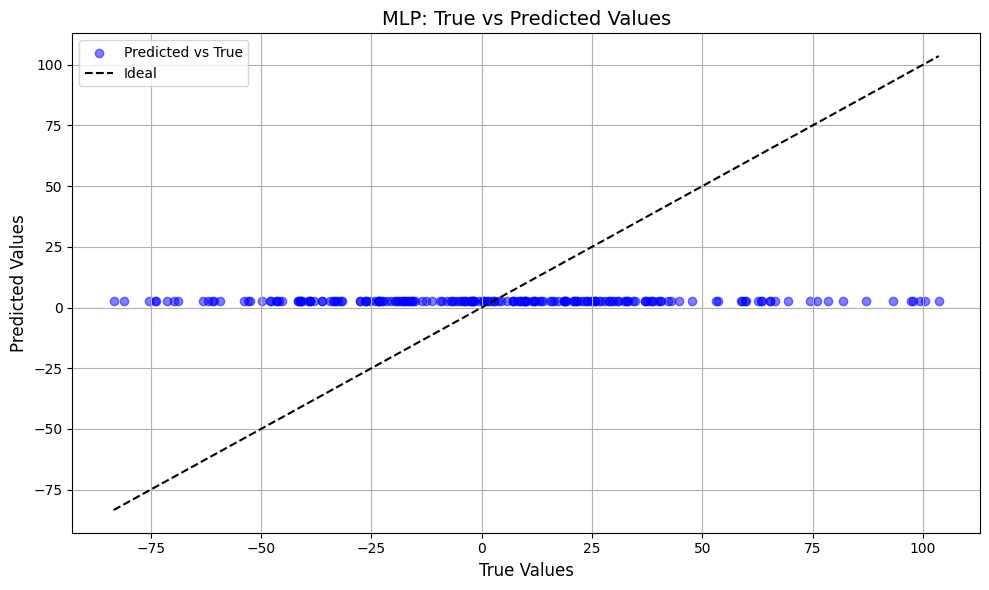

In [25]:
print("Biểu đồ 2D của MLP (True vs Predicted):")
y_pred_mlp = model_mlp.predict(X_val_mlp).ravel()
model_mlp.plot_2d_prediction(X_val_mlp, y_val_mlp, y_pred_mlp)
print("\n")

So sánh với sklearn

So sánh với mô hình sklearn MLPRegressor:
MSE - Custom: 1578.042929, Sklearn: 3.488298
R² Score - Custom: -0.000059, Sklearn: 0.997789


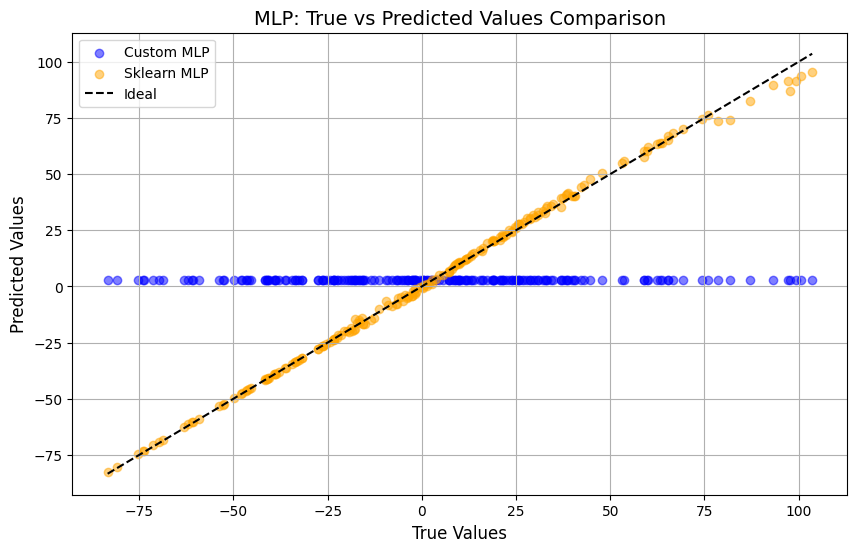

In [26]:
print("So sánh với mô hình sklearn MLPRegressor:")
compare_with_sklearn_mlp(model_mlp, X_train_mlp, y_train_mlp, X_val_mlp, y_val_mlp)
print("\n")

Vẽ biểu đồ 3D cho MLP (góc nhìn 1)

Biểu đồ 3D của MLP (Góc nhìn 1 - elev=20, azim=70):


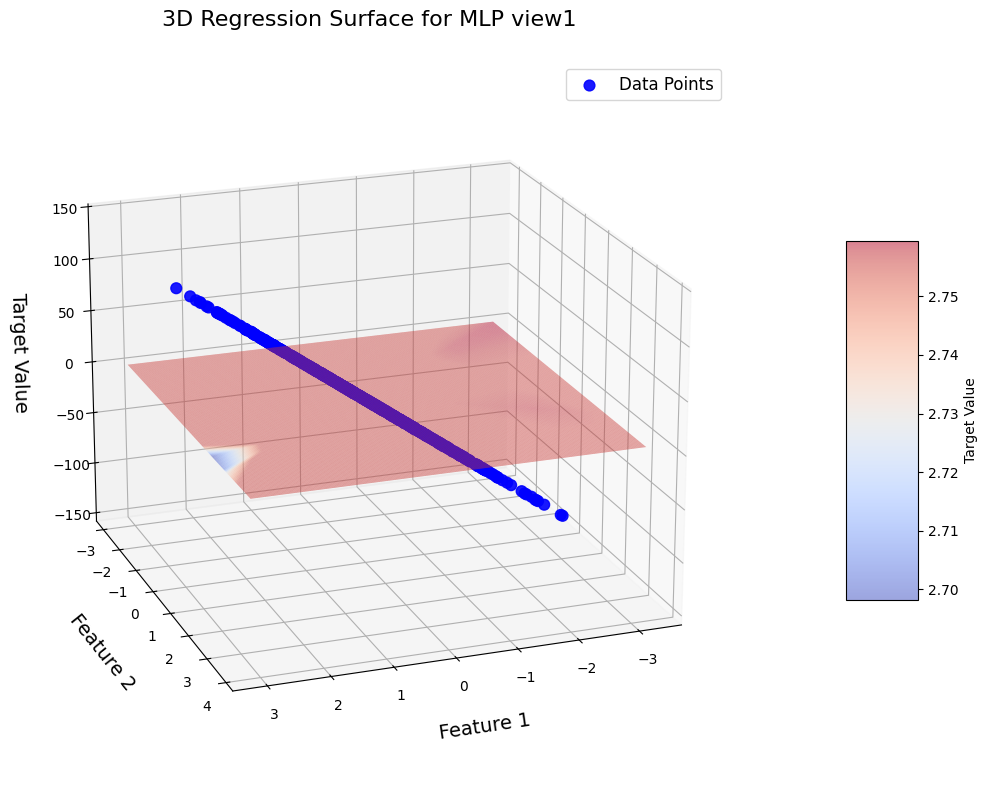

In [27]:
print("Biểu đồ 3D của MLP (Góc nhìn 1 - elev=20, azim=70):")
model_mlp.plot_3d_regression_surface(X_mlp, y_mlp, elev=20, azim=70, title_suffix="view1")
print("\n")

Vẽ biểu đồ 3D cho MLP (góc nhìn 2)

Biểu đồ 3D của MLP (Góc nhìn 2 - elev=45, azim=45):


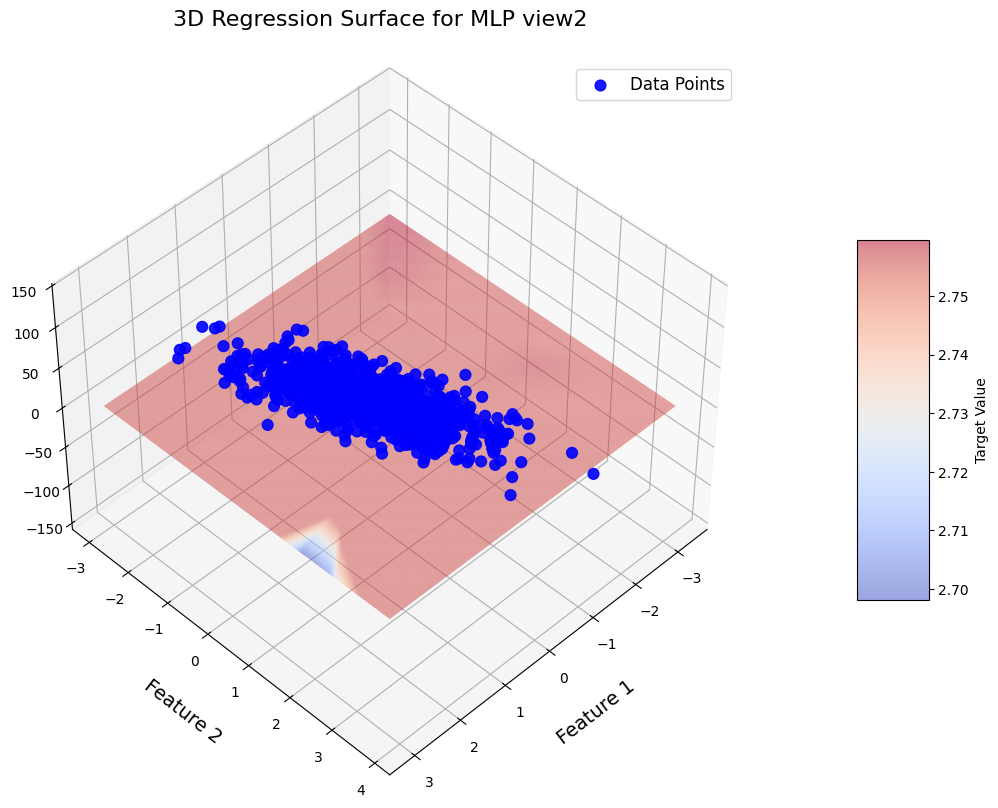

In [28]:
print("Biểu đồ 3D của MLP (Góc nhìn 2 - elev=45, azim=45):")
model_mlp.plot_3d_regression_surface(X_mlp, y_mlp, elev=45, azim=45, title_suffix="view2")
print("\n")